# Synthetic Experiments: Subgroup Discovery Performance vs. Sample Size

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import norm, sem
from tqdm import tqdm
from lineartree import LinearTreeRegressor
from copy import deepcopy

from utils.data_loader import *
from utils.methods import *

np.random.seed(103)

def gen_data(n, d, std_in, std_out, beta, R, B):
    X = (B[:, 1] - B[:, 0]) * np.random.rand(n, d) + B[:, 0]
    X = np.concatenate([X, np.ones((n, 1))], axis = 1)
    Y = np.zeros(n)
    for i, x in enumerate(X):
        if in_box(x[:-1], R):
            Y[i] = np.dot(x, beta) + std_in * np.random.randn()
        else:
            Y[i] = std_out * np.random.randn()
    return X, Y


# DDGroup methods
# Get labels from generic threshold
def get_labels(X, Y, g1, g2, std, beta):
    n = len(Y)
    labels = np.zeros(n)
    for k in range(n):
        x = X[k]
        y = Y[k]
        if res(x, y, beta) > std * (g1 * np.linalg.norm(x) + g2):
            labels[k] = 1
    return labels


# LMT methods
# Method for reconstructing bounding box from LMT node
# Input: B, LMT, node
# Output: Region described by node + B
def path_to_node(node, LMT):
    summary = LMT.summary()
    if node == 0:
        return [0]
    else:
        for other_node in summary:
            if node in summary[other_node]['children']:
                parent = other_node
                return path_to_node(parent, LMT) + [node]
        raise Exception(f"Error: Node {node} not found in LMT.")


def node_to_region(node, LMT, B):
    path = path_to_node(node, LMT)
    if len(path) == 1:
        return deepcopy(B)
    
    summary = LMT.summary()
    R_hat = deepcopy(B)
    for i in range(len(path) - 1):
        current_node = path[i]
        next_node = path[i+1]
        assert next_node in summary[current_node]['children'], f"Invalid path: Node {next_node} is not a child of node {current_node}."
        if next_node == summary[current_node]['children'][0]: # Next node is the left child of current node, meaning this split constitutes an *upper* bound
            R_hat[summary[current_node]['col'], 1] = summary[current_node]['th']
        else: # Otherwise, next node is the right child, so this split is a *lower* bound.
            R_hat[summary[current_node]['col'], 0] = summary[current_node]['th']
    
    return R_hat


# Constants
d = 2
std_in = 0.3
std_out = 5.
bias = 10.

beta = np.array([1., 1., 20.])
R = np.array([[-1/3, 1/3], [-1/3, 1/3]])

B = np.ones((d, 2))
B[:, 0] *= -1


# Experiment parameters & method hyperparams
num_trials = 20
ns = [200, 400, 800, 1600, 3200, 6400]#, 12800]
g1s = [0.]
g2s = [2., 4., 8., 16., 32., 64.]

# DDGroup Experiment

In [20]:
import warnings
warnings.filterwarnings("ignore")

np.random.seed(100)
res_dict = {n: [] for n in ns}
cluster_res_dict = {n: [] for n in ns}
lmt_res_dict = {n: [] for n in ns}

for n in tqdm(ns):
    for rep in range(num_trials):
        X, Y = gen_data(n, d, std_in, std_out, beta, R, B)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=100)

        # DDGroup
        n_core = int(len(Y_train) / 20)
        X_core, Y_core = neighbor_core(X_train, Y_train, n_core)
        beta_hat, _, s_hat = core_fit(X_core, Y_core)
        # print(s_hat)

        valid_regions = []
        for g1 in g1s:
            for g2 in g2s:
                labels = get_labels(X_train, Y_train, g1, g2, s_hat, beta_hat)
                R_hat = hard_grow_region(X_train[:, :-1], labels, B, center = np.mean(X_core[:, :-1], axis = 0))
                
                ind_val = in_box(X_val[:, :-1], R_hat)
                X_val_incl = X_val[ind_val]
                Y_val_incl = Y_val[ind_val]

                rmse_val = np.sqrt(np.mean((X_val_incl @ beta_hat - Y_val_incl) ** 2))
                if rmse_val <= 8 * s_hat:
                    valid_regions.append(R_hat)
        
        largest_vol = 0
        for R_hat in valid_regions:
            vol = box_intersection(R_hat, R_hat)
            if vol > largest_vol:
                best_R = R_hat
                largest_vol = vol
        
        res_dict[n].append(best_R)

        
        # k-means
        # Currently, we select the region with lowest validation error, which isn't quite the same as DDGroup
        best_val_mse = np.inf
        for k in range(2, 10):
            kmeans = KMeans(n_clusters=k, random_state=100).fit(X_train)
            best_mse = np.inf
            for i in range(k):
                X_core = X_train[kmeans.labels_ == i]
                Y_core = Y_train[kmeans.labels_ == i]

                if len(Y_core) == 0:
                    continue

                beta_hat, _, s_hat = core_fit(X_core, Y_core)
                mse = np.mean((X_core @ beta_hat - Y_core) ** 2)
                if mse < best_mse:
                    best_cluster = i
                    beta_best = beta_hat
                
                X_best = X_train[kmeans.labels_ == best_cluster]
                R_hat = np.zeros((d, 2))
                for j in range(d):
                    R_hat[j, 0] = min(X_best[:, j])
                    R_hat[j, 1] = max(X_best[:, j])
                
                ind_val = in_box(X_val[:, :-1], R_hat)
                X_val_incl = X_val[ind_val]
                Y_val_incl = Y_val[ind_val]

                mse_val = np.mean((X_val_incl @ beta_hat - Y_val_incl) ** 2)
                if mse_val < best_val_mse:
                    best_cluster_region = R_hat
        
        cluster_res_dict[n].append(best_cluster_region)


        # LMT
        r = []
        for max_depth in range(1, 10):
            regr = LinearTreeRegressor(base_estimator=LinearRegression(), max_depth=max_depth)
            regr.fit(X_train, Y_train)

            info = np.array([[node, value['samples'], value['loss']] for node, value in regr.summary().items() if type(value['models']) is not tuple])
            node_use = int(info[np.argmin(info[:, 2]), 0]) 
            inds_train = (regr.apply(X_train)==node_use)
            inds_val = (regr.apply(X_val)==node_use)
            model_leaf = LinearRegression(n_jobs=-1).fit(X_train[inds_train, :], Y_train[inds_train])
            y_pred_val = model_leaf.predict(X_val[inds_val, :])
            mse_val = mean_squared_error(Y_val[inds_val], y_pred_val) 
            # MSE on validation set
            r.append([mse_val, regr, node_use])

        r = np.array(r)
        # The depth with smallest MSE on validation set
        best_lmt = np.argmin(r[:, 0])
        lmt_res_dict[n].append(node_to_region(r[best_lmt, 2], r[best_lmt, 1], B))
        



100%|██████████| 6/6 [03:10<00:00, 31.71s/it]


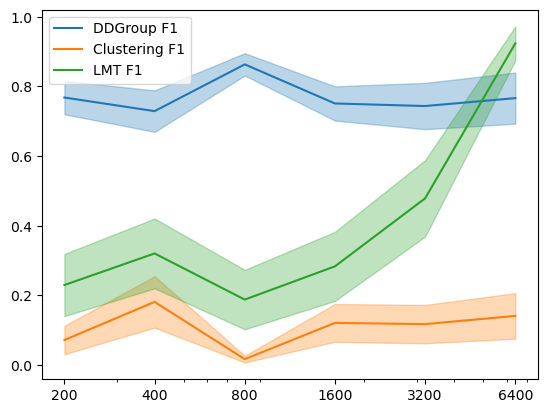

In [21]:
p_array  = np.zeros((len(ns), num_trials))
r_array  = np.zeros((len(ns), num_trials))
f1_array = np.zeros((len(ns), num_trials))

clust_p_array  = np.zeros((len(ns), num_trials))
clust_r_array  = np.zeros((len(ns), num_trials))
clust_f1_array = np.zeros((len(ns), num_trials))

lmt_p_array  = np.zeros((len(ns), num_trials))
lmt_r_array  = np.zeros((len(ns), num_trials))
lmt_f1_array = np.zeros((len(ns), num_trials))

for i, n in enumerate(ns):
    p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in res_dict[n]]
    r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in res_dict[n]]
    f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(p_array[i], r_array[i])]

    clust_p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in cluster_res_dict[n]]
    clust_r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in cluster_res_dict[n]]
    clust_f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(clust_p_array[i], clust_r_array[i])]

    lmt_p_array[i] = [0 if box_intersection(R_hat, R_hat) == 0 else box_intersection(R_hat, R) / box_intersection(R_hat, R_hat) for R_hat in lmt_res_dict[n]]
    lmt_r_array[i] = [box_intersection(R_hat, R) / box_intersection(R, R) for R_hat in lmt_res_dict[n]]
    lmt_f1_array[i] = [0 if p + r == 0 else 2 * p * r / (p + r) for p, r in zip(lmt_p_array[i], lmt_r_array[i])]


# for i, stat in enumerate([p_array, r_array, f1_array]):
# for i, stat in enumerate([p_array, r_array]):
#     line = plt.plot(ns, np.mean(stat, axis=1), label=['Precision', 'Recall', 'F1'][i])
#     plt.fill_between(ns, np.mean(stat, axis=1) + sem(stat, axis=1), np.mean(stat, axis=1) - sem(stat, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(f1_array, axis=1), label='DDGroup F1')
plt.fill_between(ns, np.mean(f1_array, axis=1) + sem(f1_array, axis=1), np.mean(f1_array, axis=1) - sem(f1_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(clust_f1_array, axis=1), label='Clustering F1')
plt.fill_between(ns, np.mean(clust_f1_array, axis=1) + sem(clust_f1_array, axis=1), np.mean(clust_f1_array, axis=1) - sem(clust_f1_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(lmt_f1_array, axis=1), label='LMT F1')
plt.fill_between(ns, np.mean(lmt_f1_array, axis=1) + sem(lmt_f1_array, axis=1), np.mean(lmt_f1_array, axis=1) - sem(lmt_f1_array, axis=1), alpha=0.3, color=line[0].get_color())


plt.xscale('log')
plt.xticks(ns, ns)
plt.legend()

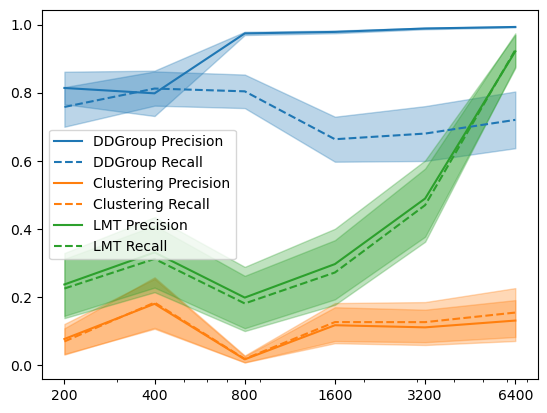

In [22]:
line = plt.plot(ns, np.mean(p_array, axis=1), label='DDGroup Precision')
plt.fill_between(ns, np.mean(p_array, axis=1) + sem(p_array, axis=1), np.mean(p_array, axis=1) - sem(p_array, axis=1), alpha=0.3, color=line[0].get_color())
plt.plot(ns, np.mean(r_array, axis=1), label='DDGroup Recall', color=line[0].get_color(), linestyle='dashed')
plt.fill_between(ns, np.mean(r_array, axis=1) + sem(r_array, axis=1), np.mean(r_array, axis=1) - sem(r_array, axis=1), alpha=0.3, color=line[0].get_color())


line = plt.plot(ns, np.mean(clust_p_array, axis=1), label='Clustering Precision')
plt.fill_between(ns, np.mean(clust_p_array, axis=1) + sem(clust_p_array, axis=1), np.mean(clust_p_array, axis=1) - sem(clust_p_array, axis=1), alpha=0.3, color=line[0].get_color())
plt.plot(ns, np.mean(clust_r_array, axis=1), label='Clustering Recall', color=line[0].get_color(), linestyle='dashed')
plt.fill_between(ns, np.mean(clust_r_array, axis=1) + sem(clust_r_array, axis=1), np.mean(clust_r_array, axis=1) - sem(clust_r_array, axis=1), alpha=0.3, color=line[0].get_color())

line = plt.plot(ns, np.mean(lmt_p_array, axis=1), label='LMT Precision')
plt.fill_between(ns, np.mean(lmt_p_array, axis=1) + sem(lmt_p_array, axis=1), np.mean(lmt_p_array, axis=1) - sem(lmt_p_array, axis=1), alpha=0.3, color=line[0].get_color())
plt.plot(ns, np.mean(lmt_r_array, axis=1), label='LMT Recall', color=line[0].get_color(), linestyle='dashed')
plt.fill_between(ns, np.mean(lmt_r_array, axis=1) + sem(lmt_r_array, axis=1), np.mean(lmt_r_array, axis=1) - sem(lmt_r_array, axis=1), alpha=0.3, color=line[0].get_color())

plt.xscale('log')
plt.xticks(ns, ns)
plt.legend()

# LMT Experiment

In [23]:
res_dict

{200: [array([[-0.37386712,  0.36924854],
         [-0.35733614,  0.36147153]]),
  array([[-0.36692616,  0.3679372 ],
         [-0.37838179,  0.4074813 ]]),
  array([[-0.35256385,  0.35323565],
         [-0.40352016,  0.37240853]]),
  array([[-0.37533539,  0.39458123],
         [-0.38494268,  0.41176683]]),
  array([[-0.37766458,  0.33950747],
         [-0.20828344,  0.30798587]]),
  array([[-0.37766458,  0.33950747],
         [-0.20828344,  0.30798587]]),
  array([[-0.43176216,  0.34873942],
         [-0.13249703,  0.45629309]]),
  array([[-0.35991828,  0.36749666],
         [-0.33406927,  0.36200264]]),
  array([[-0.16933868,  0.35157369],
         [-0.35993662,  0.3340015 ]]),
  array([[-0.16933868,  0.35157369],
         [-0.35993662,  0.3340015 ]]),
  array([[-0.16933868,  0.35157369],
         [-0.35993662,  0.3340015 ]]),
  array([[-0.448805  ,  0.40945978],
         [-0.36066482,  0.39313457]]),
  array([[-0.13727567,  0.71872058],
         [-0.91318401, -0.4287591 ]]),
  array

In [24]:
# Suddenly, all of the methods are outputting a point for the region. Why?
# This occurred after I added LMT stuff.